In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import robustnessgym

In [3]:
from spr.data.celeb import ATTRIBUTES, celeb_task_config
from spr.vision import train
import robustnessgym as rg

In [4]:
df = train.get_runs()
target_to_run = {}
for run_id in df.iloc[:len(ATTRIBUTES)].id:
    inp = train.inp(run_id)
    target_column = inp["target_column"]
    target_to_run[target_column] = run_id

In [2]:
from spr.vis import get_saliency

In [5]:
model = train.out(253).load()

/dfs/scratch0/sabri/miniconda3/envs/rg/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [6]:
from spr.data.celeb import build_celeb_df, celeb_transform

df = build_celeb_df.out(29).load()
dataset = rg.Dataset.load_image_dataset(
    df[df.split == "valid"].to_dict("records"), 
    img_columns="img_path",
    transform=celeb_transform
)

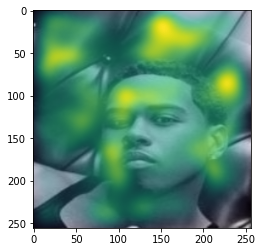

In [10]:
_ = get_saliency(
    train.out(target_to_run["brown_hair"]).load(),
    inp=dataset[21]["img_path"],
    device=0,
    sigma=10,
    threshold=0,
    show=True
)

In [15]:
from spr.vision import fit_bss
target_column = "male"
out = fit_bss(
    model=train.out(target_to_run[target_column]),
    data_df=build_celeb_df.out(29),
    target_column=target_column,
    batch_size=4,
    num_epochs=20,
    **celeb_task_config,
    config={
        "target_module": "model.layer4",
        "num_classes": 2,
        "activation_dim": 512,
        "num_components": 5,
        "lr": 1e-1,
        "cond_on_target": True,
        "dropout_prob": 0.0,
        "pred_loss_weight": 100,
        "cov_loss_weight": 1e-7,
    }
)

task: fit_bss, run_id=270
/dfs/scratch0/sabri/miniconda3/envs/rg/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Global seed set to 123
[2021-04-11 21:46:15,341][INFO][lightning:54] :: Global seed set to 123


cache_activations:   0%|          | 0/1238 [00:00<?, ?it/s]

fit_source_separator:   0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
from spr.vision import compute_bss
components, outs, targets = compute_bss(
    out, 
    data_df=build_celeb_df.out(29),
    target_column=target_column,
    **celeb_task_config,
)

task: compute_bss, run_id=271
/dfs/scratch0/sabri/miniconda3/envs/rg/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Global seed set to 123
[2021-04-11 21:48:39,810][INFO][lightning:54] :: Global seed set to 123


components:   0%|          | 0/310 [00:00<?, ?it/s]

task: visualize_component, run_id=277


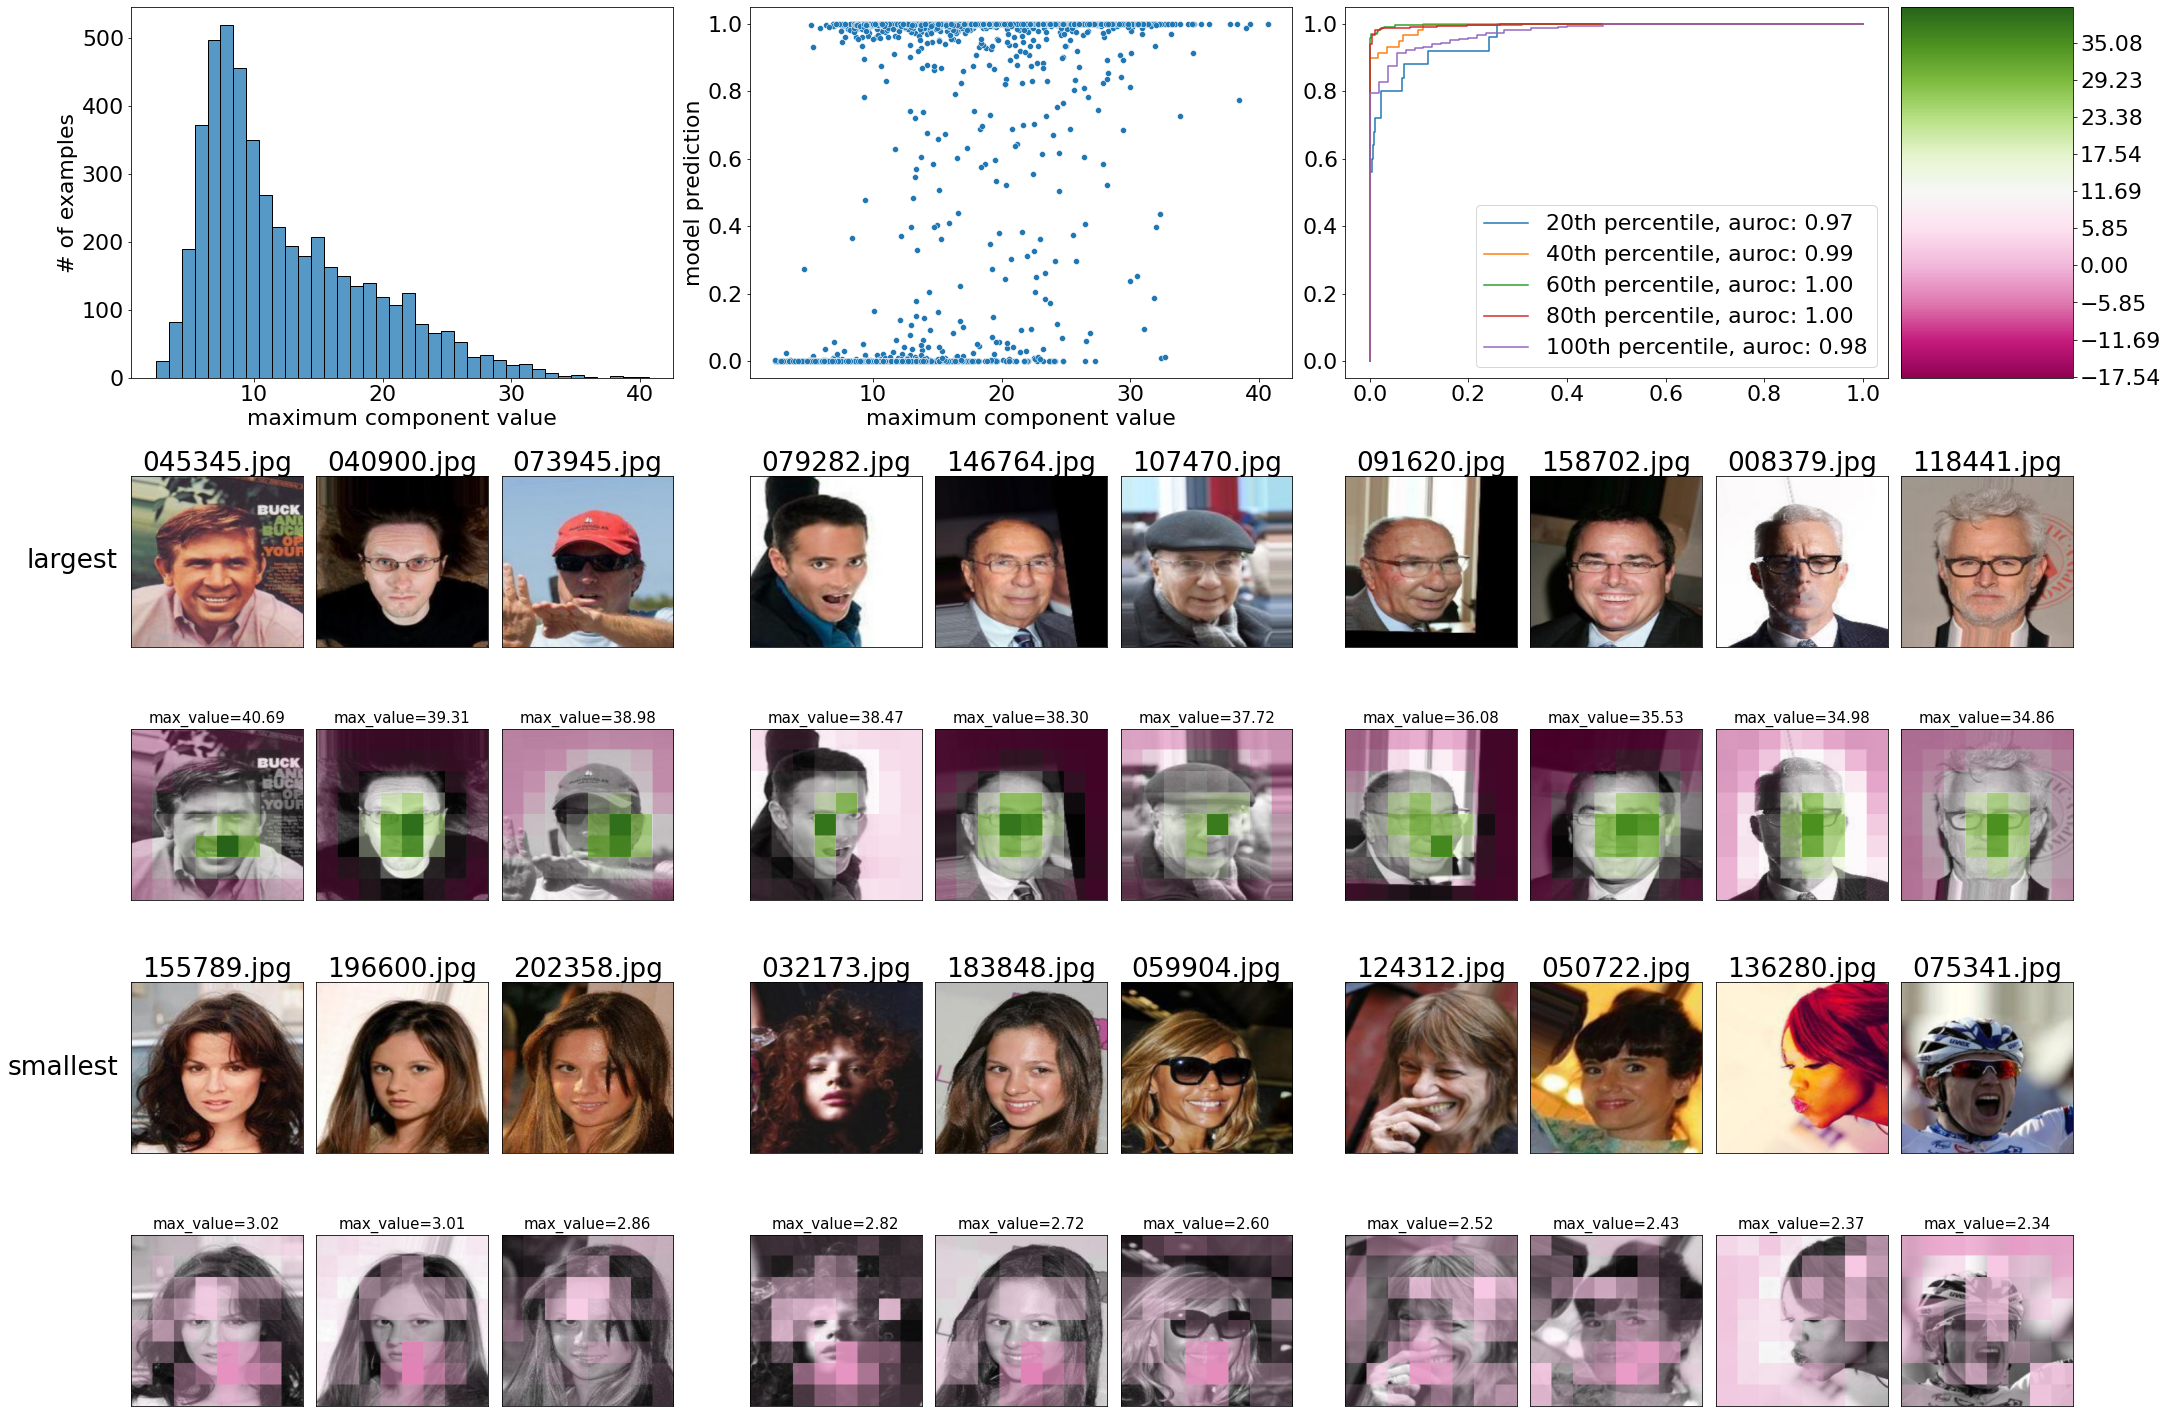

In [26]:
import torch
from spr.vis import visualize_component
#components, outs, targets = components.load(), outs.load(), targets.load()
visualize_component(
    data_df=build_celeb_df.out(29).load(),
    components=components,
    comp_idx=3,
    preds=torch.softmax(outs, dim=-1)[:, -1],
    targets=targets,
    num_examples=10,
    flip=False
);